<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/main/Data_Visualization/explore_sentinel_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with github: [A guide from Google](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

### Imports and Setup.

In [4]:
%%capture
!pip -q install geojson
!pip -q install rasterio
!pip -q install eeconvert
!pip -q install geemap
!pip install ffmpeg-python

In [5]:
# Standard imports
import os
import json
import time
import datetime
import imageio
import re

# Geospatial processing packages
import geopandas as gpd
import geojson
import shapely
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import reshape_as_image
import rasterio.mask
from shapely.geometry import box
from shapely.geometry import Polygon
from pyproj import Transformer

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.foliumap as emap
import folium
import numpy as np

### Mount your Google Drive and install project files

First, we'll mount your Google Drive as we'll save the GeoTiff files to our drive. Then we'll clone the main branch from the GitHub repo so we have access to all of the files from there.
If you want to save your files and make a pull request to github, make a new branch and check out the link at the top.

In [6]:
# mount your drive in case you have any new data uploaded there you want to use
from google.colab import drive
drive.mount('/content/drive')

# clone the main branch from GitHub to get all the data and files from there onto the current runtime session
!apt-get install git
!git clone https://github.com/liangchow/zindi-amazon-secret-runway.git
!git pull # pulls the latest changes from repo

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Cloning into 'zindi-amazon-secret-runway'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 143 (delta 50), reused 9 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (143/143), 658.59 KiB | 4.02 MiB/s, done.
Resolving deltas: 100% (50/50), done.
fatal: not a git repository (or any of the parent directories): .git


### Authenticate Google Earth Engine
Make sure you have signed up for access to Google Earth Engine. You will need to edit the following code cell to use your own account. All the Sentinel data will be downloaded through the Google Earth Engine.

In [7]:
ee.Authenticate()
ee.Initialize(project="ee-fortinpascal")

### Setup the main paths to the project files and the download location on your Google Drive.

In [8]:
airstrip_training_path = '/content/zindi-amazon-secret-runway/Data_Visualization/data/pac_2024_training/pac_2024_training.shp'
base_aoi_path = '/content/zindi-amazon-secret-runway/Data_Visualization/data/shp_test_AOIs'
illegal_runways_path = '/content/zindi-amazon-secret-runway/Data_Visualization/data/nyt_intercept_illegal_runways/Illegal-Airstrips-NYT-Intercept-Public.geojson'

# Select export folder on Google Drive
export_folder = 'Colab Notebooks'

### Define several helper functions to download and manipulate Sentinel data

In [9]:
def create_square_pentagon(center_lon, center_lat, side_length_meters):
  """
  Creates a square geopandas pentagon centered on
  a set of Lon/Lat coordinates.

  Args:
    center_lon: The longitude of the center point.
    center_lat: The latitude of the center point.
    side_length_meters: The length of each side of
                         the square in meters.

  Returns:
    A geopandas GeoDataFrame containing the pentagon.
  """

  # Define the source and destination coordinate systems
  source_crs = "EPSG:4326"  # WGS 84 (Lon/Lat)
  target_crs = "EPSG:3395"  # World Mercator (meters)


  # Create a transformer object to convert between coordinate systems
  transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)

  # Transform the center coordinates to Web Mercator
  center_x, center_y = transformer.transform(center_lon, center_lat)

  # Calculate half the side length
  half_side = side_length_meters / 2

  coordinates = [
      (center_x - half_side, center_y + half_side),  # Top left
      (center_x + half_side, center_y + half_side),  # Top right
      (center_x + half_side, center_y - half_side),  # Bottom right
      (center_x - half_side, center_y - half_side),  # Bottom Left
      (center_x - half_side, center_y + half_side)   # Top left (close the polygon)
  ]


  # Create a Polygon object from the coordinates
  polygon = Polygon(coordinates)

  # Create a GeoDataFrame from the Polygon with World Mercator CRS
  gdf = gpd.GeoDataFrame(geometry=[polygon], crs=target_crs)

  # Transform the GeoDataFrame back to WGS 84
  gdf = gdf.to_crs(source_crs)

  return gdf

In [10]:
# Function to export an image as GeoTIFF and save it to Google Drive
def export_image(image,filename_prefix,bands,export_folder):
  # Check if the image has the 'system:time_start' property.
  if 'system:time_start' in image.propertyNames().getInfo():
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    filename = f"{filename_prefix}_{date}"
  else:
    # Handle the case where the property is missing (e.g., use a default date)
    date = 'no_date'
    filename = f"{filename_prefix}_{date}"

  task = ee.batch.Export.image.toDrive(
      image=image.select(bands).clip(region),
      description='filename',
      folder=export_folder,
      fileNamePrefix=filename,
      scale=10,  # Adjust scale as needed (meters)
      region=region.getInfo()['coordinates'],
      maxPixels=1e13,
      fileFormat='GeoTIFF'
  )
  task.start()
  print(f'Task ID: {task.id}')
  print('Exporting to Google Drive...')


In [11]:
def check_all_tasks_completed():
  """Checks if all Earth Engine tasks have completed.

  Returns:
    bool: True if all tasks have completed, False otherwise.
  """

  tasks = ee.batch.Task.list()
  for task in tasks:
    if task.status()['state'] != 'COMPLETED':
      return False
  return True

In [12]:
def download_s1_images(
    region,
    bands = ['VV', 'VH'],
    filename_prefix='Sentinel2',
    export_folder='Colab Notebooks',
    product='COPERNICUS/S1_GRD',
    min_date='2024-04-01',
    max_date='2024-06-01',
):

    """Generates Sentinel-1 images from Google Earth Engine using the Python Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      bands: List of bands
      filename_prefix: Filename prexix to save to disk
      export_folder: Google Drive folder to save to
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-1 images clipped to the region of interest
    """

    # Define the Sentinel-1 image collection and filter by date and region.
    sentinel1 = ee.ImageCollection(product) \
        .filterDate(min_date, max_date) \
        .filterBounds(region) \
        .filter(ee.Filter.eq('instrumentMode', 'IW'))  # Interferometric Wide (IW) swath mode

    # Apply the export function to each image in the collection.
    collection_list = sentinel1.toList(sentinel1.size())
    for i in range(sentinel1.size().getInfo()):
      image = ee.Image(collection_list.get(i))
      export_image(image=image,filename_prefix=filename_prefix,bands=bands,export_folder=export_folder)

    print("Export tasks should be complete.")


In [13]:
def download_s2_images(
    region,
    bands=['B4', 'B3', 'B2', 'B8', 'B11', 'B12'],
    filename_prefix='Sentinel2',
    export_folder='Colab Notebooks',
    product='COPERNICUS/S2_SR_HARMONIZED',
    min_date='2023-01-01',
    max_date='2024-06-01',
    cloud_pct=10
):

    """Generates cloud-filtered, Sentinel-2 images from
    Google Earth Engine using the Python Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 images clipped to the region of interest
    """

    # Generate collection of images
    sentinel2 = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))

    # Apply the export function to each image in the collection.
    collection_list = sentinel2.toList(sentinel2.size())
    for i in range(sentinel2.size().getInfo()):
      image = ee.Image(collection_list.get(i))
      export_image(image=image,filename_prefix=filename_prefix,bands=bands,export_folder=export_folder)

    print("Export tasks should be complete.")


In [14]:
def download_s2_cloud_score_composite_image(
    region,
    bands=['B4', 'B3', 'B2', 'B8', 'B11', 'B12'],
    filename_prefix='Sentinel2',
    export_folder='Colab Notebooks',
    s2_product='COPERNICUS/S2_SR_HARMONIZED',
    csPlus_product='GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED',
    min_date='2023-01-01',
    max_date='2024-06-01',
    QA_BAND='cs_cdf',
    clr_thres=0.60
):

    """Generates cloud-filtered, Sentinel-2 images from
    Google Earth Engine using the Python Earth Engine API.
    Downloads resulting composite image to Google Drive.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      s2_product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      csPlus_product (str): Earth Engine asset ID
        for the Cloud Score Plus product
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      QA_BAND (str): Use 'cs' or 'cs_cdf', depending on your use case;
        see docs for guidance.
      clr_thres (float): The threshold for masking; values between 0.50 and
        0.65 generally work well. Higher values will remove thin clouds,
        haze & cirrus shadows.
    """

    # Generate collection of images
    sentinel2 = ee.ImageCollection(s2_product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))

    # Import the Cloud Score Plus collection
    cs = ee.ImageCollection(csPlus_product)

    # Link the Sentinel-2 and Cloud Score Plus collections
    linked_collection = sentinel2.linkCollection(cs, [QA_BAND])

    # Define a function to mask clouds based on the Cloud Score Plus score
    def cloudMask(image):
        qa = image.select(QA_BAND)
        mask = qa.gte(clr_thres)
        return image.updateMask(mask)

    # Apply the cloud mask function to the linked collection
    masked_collection = linked_collection.map(cloudMask)

    # Create a median composite image
    median_composite = masked_collection.median()

    # Apply the export function.
    image = ee.Image(median_composite)
    export_image(image=image,filename_prefix=filename_prefix,bands=bands,export_folder=export_folder)
    print("Export tasks should be complete.")


In [15]:
def plot_s1_images(
    region,
    bands = ['VV', 'VH'],
    product='COPERNICUS/S1_GRD',
    min_date='2024-06-01',
    max_date='2024-07-01'
):

    """Generates Sentinel-1 images from Google Earth Engine using the Python Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      bands: List of bands
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images

    Returns:
      Map
    """

    # Define the Sentinel-1 image collection and filter by date and region.
    sentinel1 = ee.ImageCollection(product) \
        .filterDate(min_date, max_date) \
        .filterBounds(region) \
        .filter(ee.Filter.eq('instrumentMode', 'IW'))  # Interferometric Wide (IW) swath mode

    # Get the most recent image in the collection.
    most_recent_image = sentinel1.sort('system:time_start', False).first().clip(region)

    # Select the VV and VH bands.
    vv_vh_image = most_recent_image.select(['VV', 'VH'])

    # Create a map.
    location = region.centroid().coordinates().getInfo()[::-1]
    Map = geemap.Map(center=location, zoom=10, basemap='SATELLITE')

    # Add Google TERRAIN as a base map.
    Map.add_basemap('TERRAIN')

    # Define visualization parameters for the VV and VH bands.
    #vv_vis_params = {
    #    'min': -25,
    #    'max': 0,
    #    'palette': ['blue', 'white', 'green']
    #}
    vv_vis_params = {
        'min': -25,
        'max': 0,
        'palette': ['black', 'white']
    }


    vh_vis_params = {
        'min': -25,
        'max': 0,
        'palette': ['purple', 'white', 'orange']
    }

    # Make an RGB color composite image (VV,VH,VV/VH).
    rgb = ee.Image.rgb(vv_vh_image.select('VV'),
                       vv_vh_image.select('VH'),
                       vv_vh_image.select('VV').divide(vv_vh_image.select('VH')))


    # Add the S1 rgb composite to the map object.
    Map.addLayer(rgb, {'min': [-25, -25, 0], 'max': [0, 0, 2]}, 'Fake S1 RGB')

    # Add the VV band layer to the map.
    Map.addLayer(vv_vh_image.select('VV'), vv_vis_params, 'VV Band')

    # Add the VH band layer to the map.
    Map.addLayer(vv_vh_image.select('VH'), vh_vis_params, 'VH Band')

    # Add the region of interest as a layer.
    Map.addLayer(region, {}, 'Region of Interest')

    # Display the map.
    Map.addLayerControl()  # This line will add a layer control to toggle the layers on/off.
    return Map


In [16]:
def plot_s2_images(
    region,
    bands=['B4', 'B3', 'B2', 'B8', 'B11', 'B12'],
    product='COPERNICUS/S2_SR_HARMONIZED',
    min_date='2024-06-01',
    max_date='2024-07-01',
    cloud_pct=10
):

    """Generates Sentinel-2 images from Google Earth Engine using the Python Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      bands: List of bands
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images

    Returns:
      Map
    """

    # Define the Sentinel-2 image collection and filter by date and region.
    # Generate collection of images
    sentinel2 = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))

    # Get the most recent image in the collection.
    most_recent_image = sentinel2.sort('system:time_start', False).first().clip(region)

    # Select the bands to plot.
    s2_image = most_recent_image.select(bands)

    # Select all bands
    band_names = s2_image.bandNames().getInfo()

    # Create an RGB visualization layer (bands 4, 3, 2 correspond to Red, Green, Blue)
    rgb_viz_params = {
        'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue
        'min': 0,
        'max': 3000,
        'gamma': [0.95, 1.1, 1]
    }

    # Create a map.
    location = region.centroid().coordinates().getInfo()[::-1]
    Map = geemap.Map(center=location, zoom=10, basemap='SATELLITE')

    # Add Google TERRAIN as a base map.
    Map.add_basemap('TERRAIN')

    # Add all individual bands as layers
    for band in band_names:
        Map.addLayer(s2_image.select(band), {'min': 0, 'max': 3000}, f'Sentinel-2 {band}')

    # Add the RGB visualization layer
    Map.addLayer(s2_image, rgb_viz_params, 'Sentinel-2 RGB')

    # Add the region of interest as a layer.
    Map.addLayer(region, {}, 'Region of Interest')

    # Display the map.
    Map.addLayerControl()  # This line will add a layer control to toggle the layers on/off.
    return Map


In [17]:
def create_sentinel2_timelapse(region, start_date, end_date, output_video_path):
    # Load Sentinel-2 data and filter by date and region
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                  .filterDate(start_date, end_date)\
                  .filterBounds(region)\
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

    count = collection.size()
    print('Number of images in the collection:',count.getInfo())


    # Define visualization parameters for the RGB composite
    vis_params = {
        'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue bands
        'min': 0,
        'max': 3000,
        'gamma': 1.1
    }

    # Set timelapse parameters
    timelapse_params = {
        'bands': ['B4', 'B3', 'B2'],  # Use RGB bands
        'start_date': start_date,
        'end_date': end_date,
        'frequency': 'month',  # Time intervals
        'reducer': 'median',  # Use median exposure
        'date_format': 'YYYY-MM-dd',
        'dimensions': 720,
        'frames_per_second': 1,  # Adjust FPS for video
        'crs': 'EPSG:4326',
        'vis_params': vis_params
    }


    # Generate time-lapse and export to video
    timelapse = geemap.create_timelapse(
        collection=collection,
        region=region,
        out_gif=output_video_path,
        **timelapse_params
    )


In [18]:
def create_geotiff_timelapse(dir_path, output_gif):
    """
    Creates a timelapse animation from GeoTIFF files in a directory.

    Args:
        dir_path (str): Path to the directory containing GeoTIFF files.
        output_gif (str): Name of the output GIF file.
    """
    geotiff_files = [f for f in os.listdir(dir_path) if f.endswith('.tif')]
    geotiff_files.sort()  # Sort files to ensure correct order
    images = []
    for file in geotiff_files:
        file_path = os.path.join(dir_path, file)
        with rio.open(file_path) as src:
            image = src.read()
            num_bands = src.count
            bands = src.descriptions

            # Extract date from filename using regular expression
            match = re.search(r'(\d{4}-\d{2}-\d{2})', file)
            if match:
                date_str = match.group(1)
            else:
                date_str = 'Date not found'

            fig, axes = plt.subplots(1, num_bands, figsize=(30, 8))
            for i in range(num_bands):
                #show(image[i], ax=axes[i], cmap='gray', title=f'Band {i+1}')
                show(image[i], ax=axes[i], cmap='gray', title=bands[i])
            plt.suptitle(f'Date: {date_str}')  # Set date as figure title
            plt.tight_layout()
            temp_file = 'temp_plot.png'
            plt.savefig(temp_file)
            plt.close()
            images.append(imageio.imread(temp_file))
            os.remove(temp_file)
    imageio.mimsave(output_gif, images, fps=0.5)


In [19]:
def load_and_plot_geotiffs(directory, output_file, max_images=72, grid_size=(12, 6)):
    # List all GeoTIFF files in the directory
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    files.sort()  # Sort files to ensure correct order
    files = files[:max_images]  # Limit to max_images

    if len(files) == 0:
        print("No GeoTIFF files found in the directory.")
        return

    # Set up the figure (no spaces between plots, no axes)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(grid_size[1] * 2, grid_size[0] * 2))
    plt.subplots_adjust(wspace=0, hspace=0)

    # Loop through files and plot them
    for idx, file in enumerate(files):
        row, col = divmod(idx, grid_size[1])  # Calculate the row and column for the grid

        # Open the GeoTIFF file
        with rio.open(file) as src:
            # Read the RGB bands (B4, B3, B2). We need to find their indices
            # as they can be stored differently...
            bands = src.descriptions
            B4_idx = bands.index('B4') + 1
            B3_idx = bands.index('B3') + 1
            B2_idx = bands.index('B2') + 1
            b4 = src.read(B4_idx)  # Red
            b3 = src.read(B3_idx)  # Green
            b2 = src.read(B2_idx)  # Blue

            # Normalize the bands to range [0, 1] for plotting
            def normalize(band):
                return (band - band.min()) / (band.max() - band.min())

            rgb_image = np.dstack([normalize(b4), normalize(b3), normalize(b2)])

        # Plot the image in the grid
        ax = axes[row, col]
        ax.imshow(rgb_image)
        ax.axis('off')  # Disable axes
        # Overlay filename
        # Extract date from filename using regular expression
        match = re.search(r'(\d{4}-\d{2}-\d{2})', file)
        if match:
            date_str = match.group(1)
        else:
            date_str = 'Date not found'
        ax.text(0.5,
                   0.9,
                   date_str,
                   ha='center',
                   va='center',
                   transform=ax.transAxes,
                   color='white')


    # Remove remaining empty axes
    for idx in range(len(files), grid_size[0] * grid_size[1]):
        row, col = divmod(idx, grid_size[1])
        fig.delaxes(axes[row, col])

    # Save the result
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
    plt.close()


## Let's look at the Sentinel data
We'll use the airstrip training shape file. Each record contains columns for id, year of detection, largo (length probably in meters), Activo (activity status???), and geometry of type *Linestring* with coordinates (LNG LAT) which define points along the airstrip. For each airstrip, we'll define a square AOI to define a boundary when downloading Sentinel data.

### Select the bands for both Sentinel 1 and 2

In [20]:
s1_bands = ['VV', 'VH']
s2_bands = ['B4', 'B3', 'B2', 'B8', 'B11', 'B12']

### Read the shapefile for the training set and print information about the first few entries

In [21]:
# Read the shapefile for the training dataset
airstrip_training_gdf = gpd.read_file(airstrip_training_path)

# Display the data for information
print(airstrip_training_gdf.head(20).to_markdown(), "\n")
print(airstrip_training_gdf.info(), "\n")

|    |   id |   yr |    largo |   Activo | geometry                                                                                                                            |
|---:|-----:|-----:|---------:|---------:|:------------------------------------------------------------------------------------------------------------------------------------|
|  0 |    1 | 2023 |  968.918 |        0 | LINESTRING (-70.08928656863503 -13.129844039931504, -70.08052787039317 -13.128251134052485, -70.08052787039317 -13.128251134052485) |
|  1 |    2 | 2022 | 1105.49  |        0 | LINESTRING (-69.16744237255283 -13.620679758207931, -69.1728593987747 -13.612261251288524)                                          |
|  2 |    3 | 2015 |  985.018 |        0 | LINESTRING (-69.14224792429687 -13.694510447986984, -69.14189616934739 -13.685654549844925)                                         |
|  3 |    4 | 2020 |  681.914 |        0 | LINESTRING (-69.07843632939438 -13.787902019520923, -69.08404112675193 -

### Reproject the data to a projected CRS for accurate centroid calculation

In [22]:
# Temporarily reproject to a projected CRS for accurate centroid calculation
projected_airstrip_training_gdf = airstrip_training_gdf.to_crs(epsg=3395)  # World Mercator projection

For each entry in the dataset, we'll find the centroid of the airstrip *LINESTRING*, and then define a square area around it to define the boundary geometry when accessing Sentinel data.

At this time, we do not loop on all the entries...

In [ ]:
## DO NOT AUTOMATICALLY RUN THIS CELL !!!

# This cell is useful if you want to process a single entry in the training
# set. You can run on of the functions to download or plot data, etc...

my_index = 9 # Change this number to get a different airstrip.
centroid = projected_airstrip_training_gdf.geometry[my_index].centroid

# Convert the centroid back to WGS84 (LNG, LAT)
centroid_wgs84 = gpd.GeoSeries([centroid], crs=projected_airstrip_training_gdf.crs).to_crs(epsg=4326).geometry[0]

# Create a new AOI center on the centroid. The lenght of each side is 5km.
newAOI = create_square_pentagon(centroid_wgs84.x, centroid_wgs84.y, 5000)

newAOI_fc = geemap.geopandas_to_ee(newAOI)
region = newAOI_fc.geometry()

# Make sure this folder already exists on your drive
tmp_folder = f'S2_AllBands_Idx_{my_index:03}'
tmp_file_prefix = f'S2_AllBands_Idx_{my_index:03}'
download_s2_images(region,\
                   min_date='2015-07-01',\
                   max_date='2017-01-01',\
                   bands=s2_bands,\
                   filename_prefix=tmp_file_prefix,\
                   export_folder=tmp_folder)



Task ID: NTYBTEKQ4GEYU43A4RFKULYI
Exporting to Google Drive...
Task ID: U4EDURBLVEK2LHIJC473T6ZN
Exporting to Google Drive...
Task ID: ZQQKREYKJWIKJWWFGJGTZ7IJ
Exporting to Google Drive...
Task ID: USHSAJM2KA4GOXCI6USZGSXN
Exporting to Google Drive...
Task ID: N6JAY4ID6ANO3QL5FGCUBJQI
Exporting to Google Drive...
Task ID: 4VXATANUX35LBQHDT4AJVGA6
Exporting to Google Drive...
Task ID: YTATENLC6KCTOY5CB5WHNA6U
Exporting to Google Drive...
Task ID: MQRZZSTZAFSR5QKFHRU6OFD3
Exporting to Google Drive...
Task ID: 6KE5BOUYALDDLUPHX3S5RYJW
Exporting to Google Drive...
Task ID: XZNQOP4PAV5SRJ2KKLPI3LJ6
Exporting to Google Drive...
Task ID: JRG4HC256ZFEMUDRKZOVDEZT
Exporting to Google Drive...
Export tasks should be complete.


In [ ]:
## DO NOT RUN THIS CELL !!! This is work in progress. I need to keep the code for ongoing work.

newAOI_fc = geemap.geopandas_to_ee(newAOI)
region = newAOI_fc.geometry()
#download_s1_images(region, bands=s1_bands, filename_prefix='Sentinel1', export_folder=export_folder)

tmp_folder = f'Sentinel2_Idx_{my_index:03}'
print(tmp_folder)
download_s2_images(region,\
                   min_date='2015-07-01',\
                   max_date='2024-09-01',\
                   bands=s2_bands,\
                   filename_prefix='Sentinel2_idx_011',\
                   export_folder=tmp_folder)

#Map = plot_s1_images(region, bands=s1_bands)
#Map = plot_s2_images(region, bands=s2_bands)
# Access the first airstip and calculate its centroid
#airstrip = geemap.geopandas_to_ee(projected_airstrip_training_gdf.iloc[[11]]).geometry()
#Map.addLayer(airstrip, {}, 'Airstrip')
#Map

# Define the output video file
#video_file = 'sentinel2_idx_011_timelapse.gif'
# Create the time-lapse video
#create_sentinel2_timelapse(region, '2015-07-01', '2024-09-01', video_file)

Sentinel2_Idx_010
Task ID: OHOWFSEK6WHHOSDMFDDOLIHA
Exporting to Google Drive...
Task ID: GIOOANFZJDQH7FL46HK34D7U
Exporting to Google Drive...
Task ID: 3BVJRONS63NIIMVGMUDHIRKX
Exporting to Google Drive...
Task ID: XWAGZ7UGYEJIIIA32KSHYKZS
Exporting to Google Drive...
Task ID: RLXXHNLNHAN5RAXNBLSIWQMV
Exporting to Google Drive...
Task ID: JIBCKMQS3HZZPBZRENLIMB5A
Exporting to Google Drive...
Task ID: DLNBI6CND6W6B5UQTTAX7PEB
Exporting to Google Drive...
Task ID: YRBUQ77TWFAE7MSZ6D77WUY5
Exporting to Google Drive...
Task ID: FKMKH34YD22YT7S64BCWHJXV
Exporting to Google Drive...
Task ID: UCQOYYTIBXLFCDDWMXNUU4QH
Exporting to Google Drive...
Task ID: IOG5K7VHHENRA52X6CHCKZHB
Exporting to Google Drive...
Task ID: DNOPEIJ7BI2ZJJK2BW4BUBPH
Exporting to Google Drive...
Task ID: WQZ7FCKLTWDIPVZYJMMWJH2W
Exporting to Google Drive...
Task ID: P4Y7PWUHGPSLYKMZ34JJU5DL
Exporting to Google Drive...
Task ID: MJFLXHDDZQM5JYWM6LMGIJMX
Exporting to Google Drive...
Task ID: SX7YJB4MH5W3FNG5SI3WV6GZ
Exp

### Loop over all entries

This is where we loop over all entries. Right now we only use it to generate time lapse of S2 data (RGB), but it could be used for a massive data download centered on each airstrip. Use with care as it takes a while to run. You can drink multiple coffees during that time and you can't leave as Colab is interactive and inaction will disconnect the machine...

In [ ]:
# Get the current date and time
now = datetime.datetime.now()
# Format the timestamp as YEAR-MONTH-DAY
max_date = now.strftime("%Y-%m-%d")
min_date = '2015-07-01' # Launch of Sentinel-2A

# This is the loop... We'll produce time lapses for all training entries
for index, row in projected_airstrip_training_gdf.iterrows():
    if index == 0:
        # Access the airstrip geometry and get the centroid.
        tmp_centroid = row['geometry'].centroid
        # Convert the centroid back to WGS84 (LNG, LAT)
        tmp_centroid_wgs84 = gpd.GeoSeries([tmp_centroid], crs=projected_airstrip_training_gdf.crs).to_crs(epsg=4326).geometry[0]
        # Create a new AOI center on the centroid. The lenght of each side is 5km.
        tmp_AOI = create_square_pentagon(tmp_centroid_wgs84.x, tmp_centroid_wgs84.y, 5000)
        tmp_AOI_fc = geemap.geopandas_to_ee(tmp_AOI)
        region = tmp_AOI_fc.geometry()
        video_file = f'sentinel2_idx_{index:03}_timelapse.gif'
        # Create the time-lapse video
        #aoi = ee.Geometry.Point([-110.9742, 32.2540]).buffer(1000)
        #create_sentinel2_timelapse(aoi, min_date, '2019-06-01', video_file)
        create_sentinel2_timelapse(region, min_date, max_date, video_file)

Number of images in the collection: 22
Generating URL...
Please wait ...
The GIF image has been saved to: /content/drive/MyDrive/S2_AllBands_Idx_009/sentinel2_idx_000_timelapse.gif


In [ ]:
# DELETE THIS CELL BEFORE COMMITING CHANGES

# This cell is useful if you want to process a single entry in the training
# set. You can run on of the functions to download or plot data, etc...

my_index = 9 # Change this number to get a different airstrip.
centroid = projected_airstrip_training_gdf.geometry[my_index].centroid

# Convert the centroid back to WGS84 (LNG, LAT)
centroid_wgs84 = gpd.GeoSeries([centroid], crs=projected_airstrip_training_gdf.crs).to_crs(epsg=4326).geometry[0]

# Create a new AOI center on the centroid. The lenght of each side is 5km.
newAOI = create_square_pentagon(centroid_wgs84.x, centroid_wgs84.y, 5000)

newAOI_fc = geemap.geopandas_to_ee(newAOI)
region = newAOI_fc.geometry()

# Make sure this folder already exists on your drive
tmp_folder = f'S2_AllBands_Idx_{my_index:03}'
tmp_file_prefix = f'S2_AllBands_Idx_{my_index:03}'

# Check how may images are available for different cloud threshold cut values

#sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
#        .filterBounds(region)\
#        .filterDate('2015-07-01', '2019-09-01')\
#        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 100))

#count = sentinel2.size()
#print('Number of images in the collection:',count.getInfo())

# Apply the export function to each image in the collection.
#collection_list = sentinel2.toList(sentinel2.size())
#for i in range(sentinel2.size().getInfo()):
#    image = ee.Image(collection_list.get(i))
#    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
#    print('Image date:',date)


#download_s2_images(region,\
#                   min_date='2024-01-01',\
#                   max_date='2025-01-01',\
#                   bands=s2_bands,\
#                   filename_prefix=tmp_file_prefix,\
#                   export_folder=tmp_folder,\
#                   cloud_pct=100)

download_s2_cloud_score_composite_image(region,\
                                        bands=s2_bands,\
                                        filename_prefix=tmp_file_prefix,\
                                        export_folder=tmp_folder,\
                                        min_date='2022-01-01',\
                                        max_date='2023-01-01',\
                                        QA_BAND='cs_cdf',\
                                        clr_thres=0.60)



Task ID: TAF3XMGCTWCC2XMCFYNEA2BN
Exporting to Google Drive...
Export tasks should be complete.


In [ ]:
# Example usage
directory = '/content/drive/MyDrive/S2_AllBands_Idx_009'
output_file = 'geotiff_mosaic.png'
load_and_plot_geotiffs(directory, output_file)


In [20]:
# This cell is used to download all the S2 data for the training set and use the
# year of detection in the database as a starting point.
#
#   Steps:
#     - Create a working directory in your Google drive if it doesn't
#       already exist.
#     - Start loop over all training airstrips.
#        - Extract year of detection from database and create timestamps
#        - Download the Sentinel 2 images as GeoTIFF files
#        - Create composite image with up to 72 separate exposures
#        - Delete the .tif files and move to next entry.

if not os.path.exists('/content/drive/MyDrive/Sentinel2_temp'):
    os.makedirs('/content/drive/MyDrive/Sentinel2_temp')
!cd /content/drive/MyDrive/Sentinel2_temp

for index, row in projected_airstrip_training_gdf.iterrows():
    if index == 1:
        # Access the airstrip geometry and get the centroid.
        tmp_centroid = row['geometry'].centroid
        # Convert the centroid back to WGS84 (LNG, LAT)
        tmp_centroid_wgs84 = gpd.GeoSeries([tmp_centroid], crs=projected_airstrip_training_gdf.crs).to_crs(epsg=4326).geometry[0]
        # Create a new AOI center on the centroid. The lenght of each side is 5km.
        tmp_AOI = create_square_pentagon(tmp_centroid_wgs84.x, tmp_centroid_wgs84.y, 5000)
        tmp_AOI_fc = geemap.geopandas_to_ee(tmp_AOI)
        region = tmp_AOI_fc.geometry()

        # Get the year of detection and create timestamps for data extraction
        tmp_year = row['yr']
        tmp_min_date = f'{tmp_year}-01-01'
        tmp_max_date = f'{tmp_year}-12-31'

        # Make sure this folder already exists on your drive
        tmp_folder = "Sentinel2_temp"
        tmp_file_prefix = f'S2_AllBands_Idx_{index:03}'


        download_s2_images(region,\
                           min_date=tmp_min_date,\
                           max_date=tmp_max_date,\
                           bands=s2_bands,\
                           filename_prefix=tmp_file_prefix,\
                           export_folder=tmp_folder,\
                           cloud_pct=100)


        while not check_all_tasks_completed():
            print("Tasks still running. Waiting 60 seconds...")
            time.sleep(60)
        print("All tasks completed")

        directory = '/content/drive/MyDrive/Sentinel2_temp'
        output_file = f'{directory}/S2_RGB_time_series_{index:03}_{tmp_year}.png'
        load_and_plot_geotiffs(directory, output_file)

        # Remove the tif files
        !rm /content/drive/MyDrive/Sentinel2_temp/*.tif


Task ID: L73ZMGKVPZENYTVJCQ3KAFGE
Exporting to Google Drive...
Task ID: WFQA75EDK2O62ZDVV3L7WWW5
Exporting to Google Drive...
Task ID: O4TK4CTADB4SRT4FVK527SL6
Exporting to Google Drive...
Task ID: N7UF5UZKHEWTHEDJ3ZPYVVKR
Exporting to Google Drive...
Task ID: TUQ6HFVUCNKADCTTLUC3FOE5
Exporting to Google Drive...
Task ID: VKRYZZPHUCW2GFXY747U6L4F
Exporting to Google Drive...
Task ID: H75DTPGJJVYT3QGIESRMYCX3
Exporting to Google Drive...
Task ID: XHBRNPILOZTRQMXSRMUIP273
Exporting to Google Drive...
Task ID: ZGRHDOSGPWKLSZIZV65USRYD
Exporting to Google Drive...
Task ID: HGA77SG44JIWRFJ6PDEFTMYU
Exporting to Google Drive...
Task ID: CEUNM5X7KNOVS7DODZN66UZF
Exporting to Google Drive...
Task ID: ILCD6J4QMLF7LYPPJKZV63TX
Exporting to Google Drive...
Task ID: FFQNJST4M6PVK6JCLYC76YAB
Exporting to Google Drive...
Task ID: HZ5GMW5IEJIDGDSMUKAIEJ4E
Exporting to Google Drive...
Task ID: 6U6RVSAHJQ6ONBDY2DDLOHAJ
Exporting to Google Drive...
Task ID: PFDJVEFYFPBXRYISSCYNFR27
Exporting to Google D

In [24]:
# This cell is used to create cloudless composite images using the  S2 data
# for the training set. We'll get images for all years starting in 2019
#
#   Steps:
#     - Create a working directory in your Google drive if it doesn't
#       already exist.
#     - Start loop over all training airstrips.

if not os.path.exists('/content/drive/MyDrive/Sentinel2_temp'):
    os.makedirs('/content/drive/MyDrive/Sentinel2_temp')
!cd /content/drive/MyDrive/Sentinel2_temp

for index, row in projected_airstrip_training_gdf.iterrows():
    if index >= 20 and index <60:
        # Access the airstrip geometry and get the centroid.
        tmp_centroid = row['geometry'].centroid
        # Convert the centroid back to WGS84 (LNG, LAT)
        tmp_centroid_wgs84 = gpd.GeoSeries([tmp_centroid], crs=projected_airstrip_training_gdf.crs).to_crs(epsg=4326).geometry[0]
        # Create a new AOI center on the centroid. The lenght of each side is 5km.
        tmp_AOI = create_square_pentagon(tmp_centroid_wgs84.x, tmp_centroid_wgs84.y, 5000)
        tmp_AOI_fc = geemap.geopandas_to_ee(tmp_AOI)
        region = tmp_AOI_fc.geometry()

        # Make sure this folder already exists on your drive
        tmp_folder = "Sentinel2_temp"

        # Loop over the entire data set.
        for year in range(2015, 2025):
            tmp_min_date = f'{year}-01-01'
            tmp_max_date = f'{year}-12-31'
            tmp_file_prefix = f'S2_AllBands_Idx_{index:03}_Year_{year}'

            download_s2_cloud_score_composite_image(region,
                                        bands=s2_bands,
                                        filename_prefix=tmp_file_prefix,
                                        s2_product='COPERNICUS/S2_HARMONIZED',
                                        export_folder=tmp_folder,
                                        min_date=tmp_min_date,
                                        max_date=tmp_max_date,
                                        QA_BAND='cs_cdf',
                                        clr_thres=0.60)


Task ID: WWMMU5MFVVSU7NR7GWDQU6IO
Exporting to Google Drive...
Export tasks should be complete.
Task ID: MVNFNL4YPDKXWDUSNDXVVK55
Exporting to Google Drive...
Export tasks should be complete.
Task ID: D3OR2DQBX535O7KQA5E4VNWJ
Exporting to Google Drive...
Export tasks should be complete.
Task ID: IO34IQGH7JVPXWXPRR5KZCK4
Exporting to Google Drive...
Export tasks should be complete.
Task ID: KX2HNBJG5WRV7A4HBWFYUQAO
Exporting to Google Drive...
Export tasks should be complete.
Task ID: 257S5ZH7U7ZLZ3D2DTXKL47N
Exporting to Google Drive...
Export tasks should be complete.
Task ID: ZX73UCDLPAIXCZDMYOYSFF6I
Exporting to Google Drive...
Export tasks should be complete.
Task ID: JPCOXC7Q7OIUPMKXIIGIUFSB
Exporting to Google Drive...
Export tasks should be complete.
Task ID: Z752CVFOMY7RQBNQF2F6IEFR
Exporting to Google Drive...
Export tasks should be complete.
Task ID: F3S7MMLFBRA5EDQL67JHOE3N
Exporting to Google Drive...
Export tasks should be complete.
Task ID: N5PH66YMG73DITMF7XVKOTEW
Export

In [23]:
## DO NOT AUTOMATICALLY RUN THIS CELL !!!

# Path to directory with a series of GeoTIFF files
geotiff_path = '/content/drive/MyDrive/Sentinel2_temp'
%cd "$geotiff_path"

for index, row in projected_airstrip_training_gdf.iterrows():
    if index >= 0 and index <20:

        pattern = f'Idx_{index:03}'
        geotiff_files = []
        images = []

        for filename in os.listdir(geotiff_path):
            if pattern in filename and filename.endswith('.tif'):
                filepath = os.path.join(geotiff_path, filename)
                geotiff_files.append(filepath)

        geotiff_files.sort()  # Sort datasets to ensure correct order
        for file in geotiff_files:
            with rio.open(file) as src:
                image = src.read()
                num_bands = src.count
                bands = src.descriptions
                # Extract year from filename using regular expression
                match = re.search(r'(\d{4})', file)
                if match:
                    date_str = match.group(1)
                else:
                    date_str = 'Date not found'


                fig, axes = plt.subplots(1, num_bands, figsize=(30, 8))
                for i in range(num_bands):
                    show(image[i], ax=axes[i], cmap='gray', title=bands[i])
                plt.suptitle(f'Idx: {index:03} Date: {date_str}')  # Set date as figure title
                plt.tight_layout()
                temp_file = 'temp_plot.png'
                plt.savefig(temp_file)
                plt.close()
                images.append(imageio.v2.imread(temp_file))
                os.remove(temp_file)
        output_gif = f'S2_AllBands_Idx_{index:03}_cloudless_timelapse.gif'
        imageio.mimsave(output_gif, images, fps=0.5)


/content/drive/MyDrive/Sentinel2_temp


In [29]:
def plot_histograms(gdf, columns, bins=10, figsize=(10, 6)):
  """Plots histograms of selected columns in a GeoDataFrame.

  Args:
    gdf: The GeoDataFrame containing the data.
    columns: A list of column names to plot histograms for.
    bins: The number of bins to use for the histograms (default: 10).
    figsize: The size of the figure to create (default: (10, 6)).
  """

  fig, axes = plt.subplots(len(columns), 1, figsize=figsize)  # Create subplots

  for i, column in enumerate(columns):
    ax = axes[i] if len(columns) > 1 else axes  # Handle single subplot case
    gdf[column].hist(ax=ax, bins=bins)  # Plot histogram
    # Calculate and overlay mean and standard deviation
    mean = gdf[column].mean()
    std = gdf[column].std()
    ax.axvline(mean, color='r', linestyle='--', label='Mean')
    ax.axvline(mean + std, color='g', linestyle='-.', label='Std Dev')
    ax.axvline(mean - std, color='g', linestyle='-.')


    ax.set_title(f'Histogram of {column}')  # Set title
    ax.set_xlabel(column)  # Set x-axis label
    ax.set_ylabel('Frequency')  # Set y-axis label
    ax.legend() # Add legend to display mean and std dev lines

  plt.tight_layout()  # Adjust layout
  plt.show()  # Display the plot

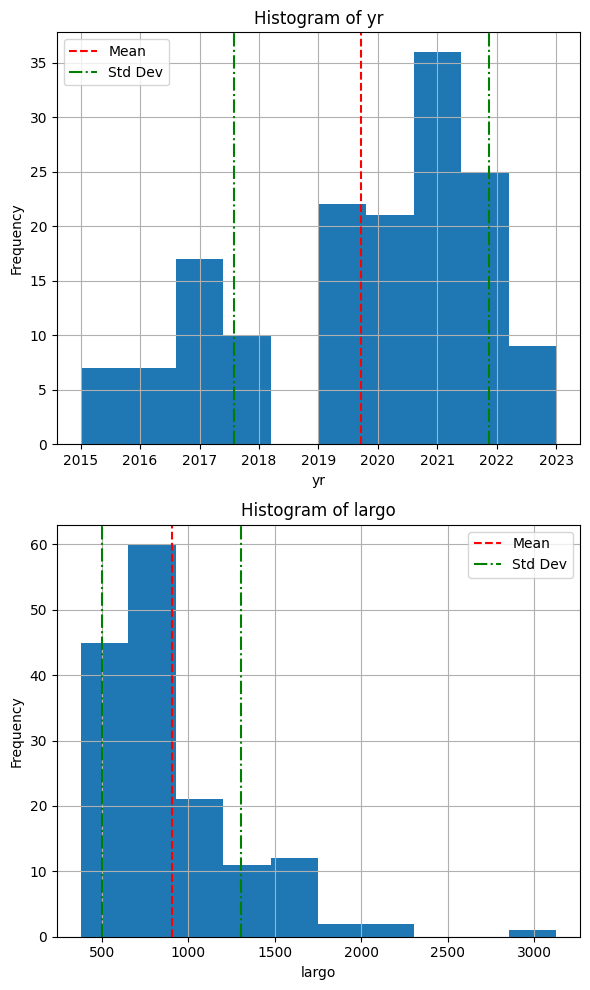

In [32]:
columns_to_plot = ['yr', 'largo']
plot_histograms(projected_airstrip_training_gdf, columns_to_plot,figsize=(6,10))